In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# pd.set_option('display.max_rows', 100, 'display.min_rows', 20)

In [2]:
plt.rcParams['figure.figsize']=(15,10)

In [3]:
crsp = pd.read_csv('crsp_filtered2.csv')
crsp.head()

,Unnamed: 0,date,permno,prc,ret,relvol,size,prc_clipped,relvol_clipped,size_clipped,tgt_ret,tgt_label,mom3m,mom6m,mom12m,sz_cat,tgt_label2
0,12,2001-01-31,80000,20.1250,0.025478,0.052441,11.180602,20.1250,0.052441,11.180602,-0.003106,3.0,0.019481,0.226563,0.171642,5,0.0
1,13,2001-02-28,80000,20.0625,-0.003106,0.023352,11.151626,20.0625,0.023352,11.151626,0.099688,1.0,0.080537,0.183824,0.229008,5,1.0
2,14,2001-03-30,80000,22.0625,0.099688,0.072649,11.244636,22.0625,0.072649,11.244636,-0.027989,6.0,0.022293,0.163043,0.360169,5,-1.0
3,15,2001-04-30,80000,21.4450,-0.027989,0.055857,11.216248,21.4450,0.055857,11.216248,0.010026,5.0,0.096273,0.146104,0.548246,5,1.0
4,16,2001-05-31,80000,21.6600,0.010026,0.025983,11.231117,21.6600,0.025983,11.231117,-0.021237,5.0,0.068910,0.151409,0.394797,5,-1.0


In [4]:
# train set: ~ 2009-12-31
# test set: 2010-01-01 ~
train = crsp[crsp.date < '2010-01-01']
test = crsp[crsp.date >= '2010-01-01']

x_cols = ['mom3m','mom6m','mom12m', "ret", "size_clipped", "relvol_clipped", "prc_clipped"] # input features
x_train = train[x_cols].values
y_train = train['tgt_label'].values
x_test = test[x_cols].values
y_test = test['tgt_label'].values

In [5]:
from sklearn.ensemble import AdaBoostClassifier

In [6]:
clf2 = AdaBoostClassifier()

In [8]:
clf2.fit(x_train,y_train)

AdaBoostClassifier()

In [9]:
# in-sample (train set) accuracy
clf2.score(x_train, y_train) 

# out-of-sample (test set) accuracy
clf2.score(x_test, y_test)

0.13535614500648813

0.13189889224854603

In [12]:
# 'W' and 'L' portfolio returns
r_w_ew = []; r_l_ew = []  # equal-weight 
r_w_vw = []; r_l_vw = []  # value-weight

# predict in each month during the test period
for m, test_m in test.groupby('date'):
    x_test_m = test_m[x_cols].values
    
    # Predict the return class
    y_pred = clf2.predict(x_test_m)
    widx = y_pred==0 # highest return class
    lidx = y_pred==9 # lowest return class
    
    rw = test_m.loc[widx, 'tgt_ret'] # returns of class 'W'
    rl = test_m.loc[lidx, 'tgt_ret'] # returns of class 'L'
    
    print(f'{m} Number of stocks in W and L: {len(rw)}, {len(rl)}')

    # equal-weight
    # portfolio weights
    ww_ew = (1/len(rw) if len(rw) else 0) * np.ones_like(rw)
    wl_ew = (1/len(rl) if len(rl) else 0) * np.ones_like(rl)
    
    # portfolio return
    r_w_ew.append(np.matmul(ww_ew, rw))
    r_l_ew.append(np.matmul(wl_ew, rl))

    # value-weight
    # portfolio weights
    sizew = np.exp(test_m.loc[widx, 'size'])
    sizel = np.exp(test_m.loc[lidx, 'size'])
    ww_vw = sizew/np.sum(sizew)
    wl_vw = sizel/np.sum(sizel)

    # portfolio return
    r_w_vw.append(np.matmul(ww_vw, rw))
    r_l_vw.append(np.matmul(wl_vw, rl))
    

r_w_ew = np.array(r_w_ew)
r_l_ew = np.array(r_l_ew)
# long-short portfolio return
r_wl_ew = r_w_ew - r_l_ew 

r_w_vw = np.array(r_w_vw)
r_l_vw = np.array(r_l_vw)
# long-short portfolio return
r_wl_vw = r_w_vw - r_l_vw

2010-01-29 Number of stocks in W and L: 285, 79
2010-02-26 Number of stocks in W and L: 189, 130
2010-03-31 Number of stocks in W and L: 198, 168
2010-04-30 Number of stocks in W and L: 200, 136
2010-05-28 Number of stocks in W and L: 338, 75
2010-06-30 Number of stocks in W and L: 249, 85
2010-07-30 Number of stocks in W and L: 99, 123
2010-08-31 Number of stocks in W and L: 153, 69
2010-09-30 Number of stocks in W and L: 30, 147
2010-10-29 Number of stocks in W and L: 91, 89
2010-11-30 Number of stocks in W and L: 139, 94
2010-12-31 Number of stocks in W and L: 104, 91
2011-01-31 Number of stocks in W and L: 186, 70
2011-02-28 Number of stocks in W and L: 143, 72
2011-03-31 Number of stocks in W and L: 139, 90
2011-04-29 Number of stocks in W and L: 119, 68
2011-05-31 Number of stocks in W and L: 165, 53
2011-06-30 Number of stocks in W and L: 187, 64
2011-07-29 Number of stocks in W and L: 129, 70
2011-08-31 Number of stocks in W and L: 220, 119
2011-09-30 Number of stocks in W and 

In [13]:
r_w_ew

array([ 0.06283998,  0.09725147,  0.06925098, -0.09150424, -0.09131717,
        0.08185341, -0.06973553,  0.15017976,  0.06297559,  0.0478199 ,
        0.10172995,  0.00963662,  0.0468107 ,  0.03545128,  0.00768282,
       -0.02460507, -0.03464397, -0.03819696, -0.10301796, -0.13220532,
        0.19686154, -0.03046513,  0.02288633,  0.12047972,  0.08263513,
        0.05805408, -0.00346335, -0.07464876,  0.04552084, -0.00157048,
        0.03501912,  0.04808125, -0.0527019 , -0.00419447,  0.01182295,
        0.08847786,  0.00185256,  0.09853968,  0.03413915,  0.09713692,
        0.00258752,  0.09489127, -0.00240564,  0.09554355, -0.00299878,
        0.07175395,  0.06692305, -0.00503872,  0.07029417, -0.00240938,
       -0.0714288 ,  0.0021634 ,  0.07192604, -0.07411367,  0.09459269,
       -0.06525235,  0.04152658,  0.04478615,  0.00146828, -0.0179237 ,
        0.07186972, -0.00176281,  0.00247502,  0.03041217,  0.01467748,
       -0.03526627, -0.00655722, -0.09210004,  0.06772732,  0.09

In [14]:
def evaluate(r_p):
    cum_r = (1 + r_p).prod()-1
    mean_r = np.mean(r_p)
    std_r = np.std(r_p)
    sharpe =  mean_r / std_r

    return [cum_r, mean_r, std_r, sharpe]

In [15]:
# dataframe to store evaluation results
pftab = pd.DataFrame(0, index=['cum', 'mean', 'std', 'Sharpe'], columns=[])

pftab['EW_W'] = evaluate(r_w_ew)
pftab['EW_L'] = evaluate(r_l_ew)
pftab['EW_WL'] = evaluate(r_wl_ew)

pftab['VW_W'] = evaluate(r_w_vw)
pftab['VW_L'] = evaluate(r_l_vw)
pftab['VW_WL'] = evaluate(r_wl_vw)

pftab

,EW_W,EW_L,EW_WL,VW_W,VW_L,VW_WL
cum,5.428735,0.545618,2.627746,3.678397,0.034535,2.492709
mean,0.019632,0.006644,0.012988,0.017425,0.003559,0.013866
std,0.062494,0.070707,0.038879,0.074392,0.080202,0.062853
Sharpe,0.314146,0.093961,0.334072,0.234228,0.044371,0.220611


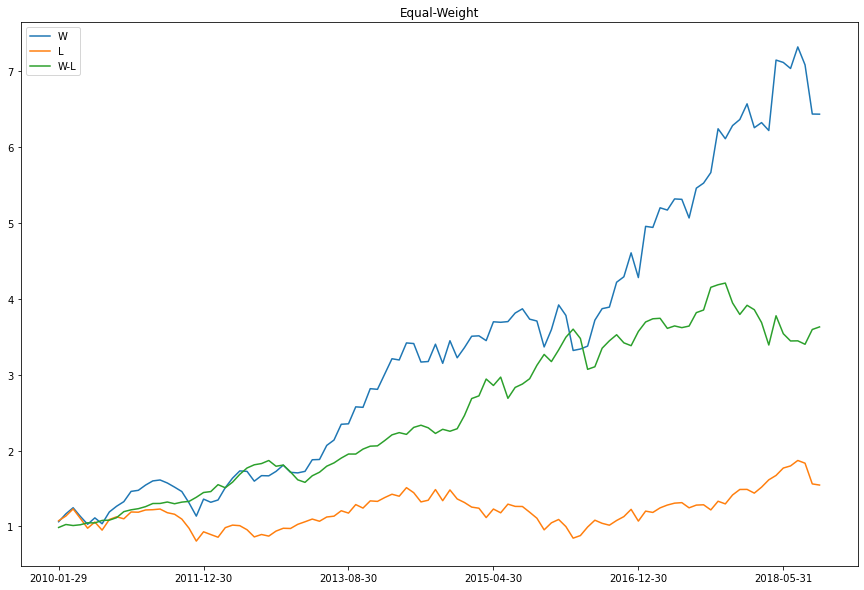

In [16]:
cumret = pd.DataFrame(0, index=test.date.unique(), columns=[])
cumret['W'] = (1 + r_w_ew).cumprod()
cumret['L'] = (1 + r_l_ew).cumprod()
cumret['W-L'] = (1 + r_wl_ew).cumprod()

cumret.plot(title='Equal-Weight')

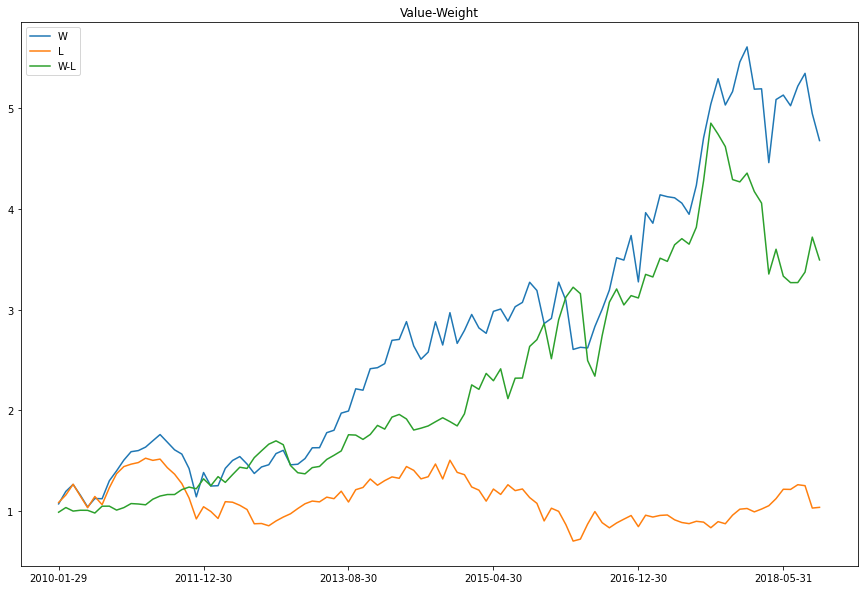

In [17]:
cumret = pd.DataFrame(0, index=test.date.unique(), columns=[])
cumret['W'] = (1 + r_w_vw).cumprod()
cumret['L'] = (1 + r_l_vw).cumprod()
cumret['W-L'] = (1 + r_wl_vw).cumprod()

cumret.plot(title='Value-Weight')